In [1]:
import ast
import pathlib
import sys

import numpy as np
import optuna
import pandas as pd
import pyarrow.parquet as pq
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")

import json

import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    data_split,
    extract_best_trial_params,
    objective_model_optimizer,
    optimized_model_create,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)
from sklearn.model_selection import train_test_split

sys.path.append("../../..")
from utils.utils import df_stats

## Papermill is used for executing notebooks in the CLI with multiple parameters
Here the `injected-parameters` cell is used to inject parameters into the notebook via papermill.
This enables multiple notebooks to be executed with different parameters, preventing to manually update parameters or have multiple copies of the notebook.

In [2]:
# Parameters
CELL_TYPE = "SHSY5Y"
MODEL_NAME = "MultiClass_MLP_h202_remove"
SHUFFLE = True

In [3]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.9527532302864088, 0.5029772224965937, 0.5442695472169975]


In [4]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [5]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [6]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [7]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [8]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [9]:
# # randomly select wells to hold out for testing one per treatment group
# # stratified by treatment group
# np.random.seed(seed=0)
# wells_to_hold = (
#     df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose")
#     .agg(np.random.choice)["Metadata_Well"]
#     .to_list()
# )
# df_holdout = df1[df1["Metadata_Well"].isin(wells_to_hold)]
# df = df1[~df1["Metadata_Well"].isin(wells_to_hold)]


# print("Wells held out for testing:", df_holdout["Metadata_Well"].unique())
# print(
#     "Wells to use for training, validation, and testing", df1["Metadata_Well"].unique()
# )

In [10]:
# # downsample healthy and pyroptosis to match number of apoptosis
# # to balance classes
# df_healthy = df1[df1["labels"] == "healthy"]
# df_pyroptosis = df1[df1["labels"] == "pyroptosis"]
# df_apoptosis = df1[df1["labels"] == "apoptosis"]
# print(df_healthy.shape, df_pyroptosis.shape, df_apoptosis.shape)
# df_healthy = df_healthy.sample(n=df_apoptosis.shape[0], random_state=0)
# df_pyroptosis = df_pyroptosis.sample(n=df_apoptosis.shape[0], random_state=0)
# print(df_healthy.shape, df_pyroptosis.shape, df_apoptosis.shape)
# df = pd.concat([df_healthy, df_pyroptosis, df_apoptosis])
# print(df.shape)
# # show that the df was downsampled and recombined correctly
# assert (df_healthy + df_pyroptosis + df_apoptosis).shape[0] == df1.shape[0]

In [11]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/SHSY5Y/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,520756,train
1,592465,train
2,10473,train
3,145418,train
4,131978,train


In [12]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(train_indexes.shape, val_indexes.shape, test_indexes.shape, holdout_indexes.shape)
assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(156754,) (39189,) (230445,) (144614,)


In [13]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_values = df1.drop(columns=df_metadata)

In [14]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_3284708/1683257534.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [15]:
print(train_indexes.shape, val_indexes.shape, test_indexes.shape, holdout_indexes.shape)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + holdout_indexes.shape[0]
)

(156754,) (39189,) (230445,) (144614,)
571002


In [16]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

In [17]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(7972,) (85003,) (63779,)
(1993,) (21251,) (15945,)
(9965,) (106254,) (114226,)
(7048,) (71293,) (66273,)


In [18]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [19]:
print(X_train.shape, X_val.shape, X_test.shape, X_holdout.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape, Y_holdout.shape)

(156754, 1251) (39189, 1251) (230445, 1251) (144614, 1251)
(156754,) (39189,) (230445,) (144614,)


#### Split Data - All Models can proceed through this point

In [20]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [21]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [22]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=mlp_params.SHUFFLE
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

In [23]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.614940).  Saving model ...
	 Train_Loss: 0.6693 Train_Acc: 68.740 Val_Loss: 0.6149  BEST VAL Loss: 0.6149  Val_Acc: 70.385

Epoch 1: Validation loss decreased (0.614940 --> 0.604309).  Saving model ...
	 Train_Loss: 0.6440 Train_Acc: 70.727 Val_Loss: 0.6043  BEST VAL Loss: 0.6043  Val_Acc: 71.683

Epoch 2: Validation loss did not decrease
	 Train_Loss: 0.6284 Train_Acc: 71.681 Val_Loss: 0.6076  BEST VAL Loss: 0.6043  Val_Acc: 70.675

Epoch 3: Validation loss decreased (0.604309 --> 0.599380).  Saving model ...
	 Train_Loss: 0.6174 Train_Acc: 72.463 Val_Loss: 0.5994  BEST VAL Loss: 0.5994  Val_Acc: 72.138

Epoch 4: Validation loss decreased (0.599380 --> 0.593276).  Saving model ...
	 Train_Loss: 0.6089 Train_Acc: 72.664 Val_Loss: 0.5933  BEST VAL Loss: 0.5933  Val_Acc: 73.516

Epoch 5: Validation loss decreased (0.593276 --> 0.586853).  Saving model ...
	 Train_Loss: 0.6014 Train_Acc: 73.146 Val_Loss: 0.5869  BEST VAL Loss: 0.5869  Val_

In [24]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


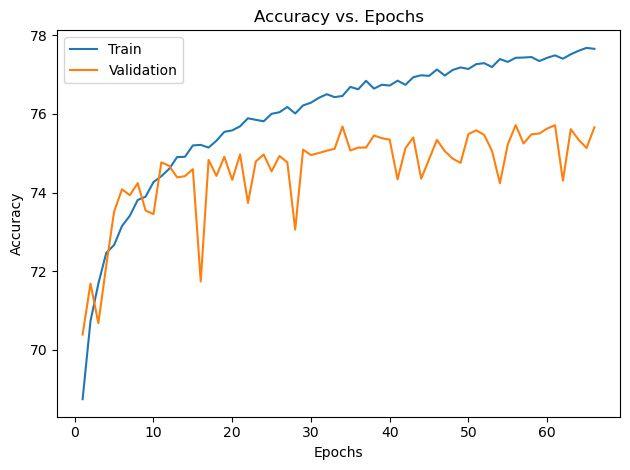

In [25]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


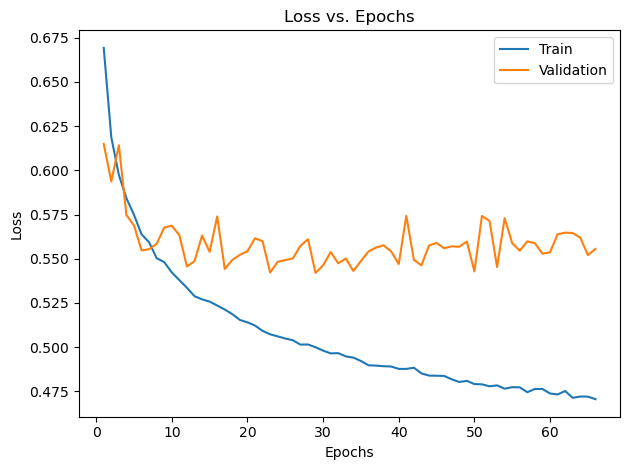

In [26]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [27]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP_h202_remove_shuffle


In [28]:
stats_df = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.05      0.05      0.05      7972
           1       0.54      0.58      0.56     85003
           2       0.41      0.36      0.38     63779

    accuracy                           0.47    156754
   macro avg       0.33      0.33      0.33    156754
weighted avg       0.46      0.47      0.46    156754



/tmp/ipykernel_3284708/3705935474.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [29]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

### Test models on Validation data

In [30]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP_h202_remove_shuffle


In [31]:
stats_df = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.05      0.06      0.05      1993
           1       0.54      0.59      0.56     21251
           2       0.41      0.36      0.38     15945

    accuracy                           0.47     39189
   macro avg       0.33      0.33      0.33     39189
weighted avg       0.46      0.47      0.46     39189



/tmp/ipykernel_3284708/603564049.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [32]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_3284708/1865218578.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [33]:
mlp_params.MODEL_NAME

'MultiClass_MLP_h202_remove'

### Testing on the test data

In [34]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [35]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP_h202_remove_shuffle


              precision    recall  f1-score   support

           0       0.05      0.05      0.05      9965
           1       0.46      0.56      0.51    106254
           2       0.50      0.39      0.44    114226

    accuracy                           0.45    230445
   macro avg       0.33      0.33      0.33    230445
weighted avg       0.46      0.45      0.45    230445

Precision for class 0: 0.048692839816728055
Recall for class 0: 0.05439036628198696
Precision for class 1: 0.46016389272196057
Recall for class 1: 0.5617859092363582
Precision for class 2: 0.4950164629722641
Recall for class 2: 0.38827412322938737
3


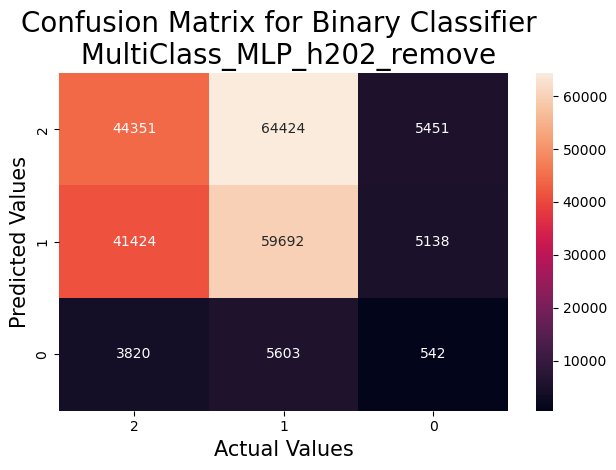

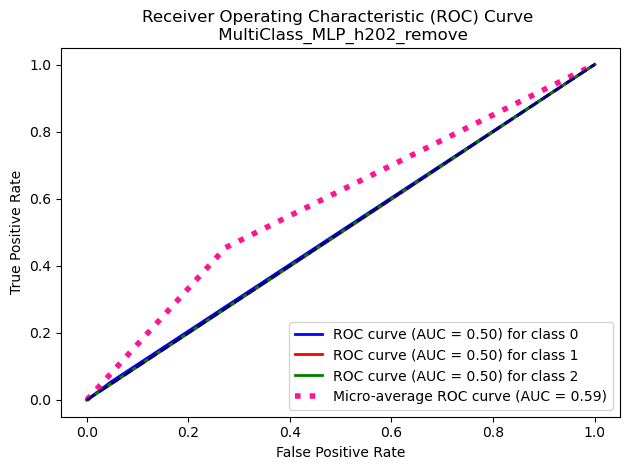

In [36]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [37]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [38]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,542,5603,3820
healthy,5138,59692,41424
pyroptosis,5451,64424,44351


In [39]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [40]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,5603,testing
1,healthy,healthy,59692,testing
2,pyroptosis,healthy,64424,testing
3,apoptosis,apoptosis,542,testing
4,healthy,apoptosis,5138,testing
5,pyroptosis,apoptosis,5451,testing
6,apoptosis,pyroptosis,3820,testing
7,healthy,pyroptosis,41424,testing
8,pyroptosis,pyroptosis,44351,testing


In [41]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [42]:
confusion_matrix_df

,apoptosis,healthy,pyroptosis
apoptosis,0.048693,0.043193,0.042636
healthy,0.461594,0.460164,0.462347
pyroptosis,0.489713,0.496643,0.495016


In [43]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

In [44]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,5603,testing,0.043193,True
1,healthy,healthy,59692,testing,0.460164,True
2,pyroptosis,healthy,64424,testing,0.496643,True
3,apoptosis,apoptosis,542,testing,0.048693,True
4,healthy,apoptosis,5138,testing,0.461594,True
5,pyroptosis,apoptosis,5451,testing,0.489713,True
6,apoptosis,pyroptosis,3820,testing,0.042636,True
7,healthy,pyroptosis,41424,testing,0.462347,True
8,pyroptosis,pyroptosis,44351,testing,0.495016,True


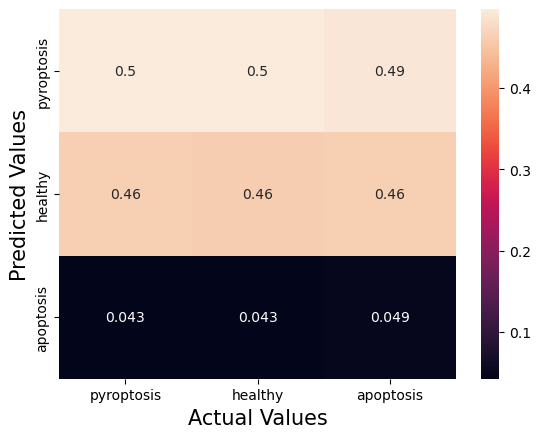

In [45]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [46]:
stats_df = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.05      0.05      0.05      9965
           1       0.46      0.56      0.51    106254
           2       0.50      0.39      0.44    114226

    accuracy                           0.45    230445
   macro avg       0.33      0.33      0.33    230445
weighted avg       0.46      0.45      0.45    230445



/tmp/ipykernel_3284708/2182903883.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [47]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_3284708/1771591469.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the hold out wells

MultiClass_MLP_h202_remove_shuffle
              precision    recall  f1-score   support

           0       0.05      0.05      0.05      7048
           1       0.49      0.57      0.53     71293
           2       0.46      0.38      0.41     66273

    accuracy                           0.46    144614
   macro avg       0.33      0.33      0.33    144614
weighted avg       0.45      0.46      0.45    144614

Precision for class 0: 0.05112863747620343
Recall for class 0: 0.053348467650397274
Precision for class 1: 0.4928249927402962
Recall for class 1: 0.5713183622515534
Precision for class 2: 0.4568043653409507
Recall for class 2: 0.3764278061955849
3


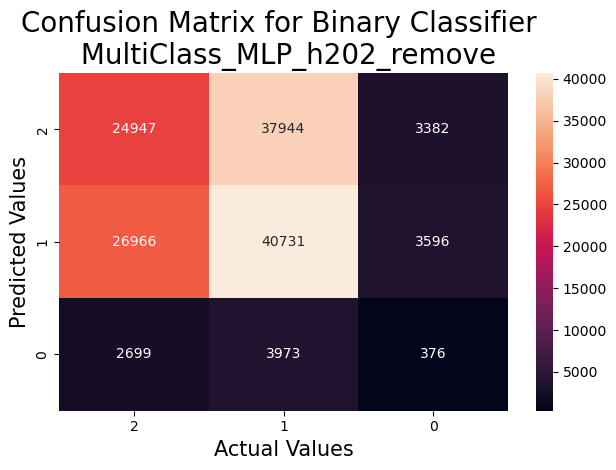

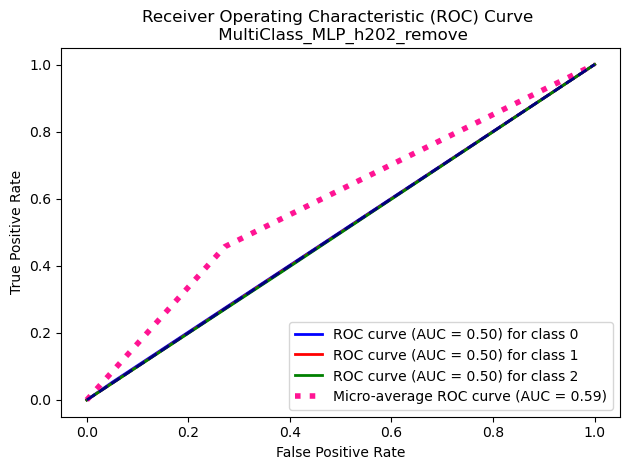

In [48]:
holdout_data = Dataset_formatter(
    torch.FloatTensor(X_holdout.values), torch.FloatTensor(Y_holdout.values)
)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [49]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [50]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [51]:
confusion_matrices

,True_Label,Predicted_Label,Count,data_split
0,apoptosis,healthy,3973,holdout
1,healthy,healthy,40731,holdout
2,pyroptosis,healthy,37944,holdout
3,apoptosis,apoptosis,376,holdout
4,healthy,apoptosis,3596,holdout
5,pyroptosis,apoptosis,3382,holdout
6,apoptosis,pyroptosis,2699,holdout
7,healthy,pyroptosis,26966,holdout
8,pyroptosis,pyroptosis,24947,holdout


In [52]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [53]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [54]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_3284708/2456365394.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


In [55]:
data_split_conf_mat_df

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,3973,holdout,0.048071,True
1,healthy,healthy,40731,holdout,0.492825,True
2,pyroptosis,healthy,37944,holdout,0.459104,True
3,apoptosis,apoptosis,376,holdout,0.051129,True
4,healthy,apoptosis,3596,holdout,0.488986,True
5,pyroptosis,apoptosis,3382,holdout,0.459886,True
6,apoptosis,pyroptosis,2699,holdout,0.049421,True
7,healthy,pyroptosis,26966,holdout,0.493774,True
8,pyroptosis,pyroptosis,24947,holdout,0.456804,True


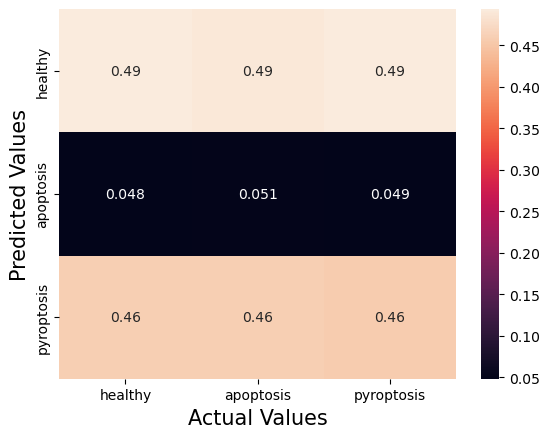

In [56]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [57]:
stats_df = output_stats(
    y_pred_list,
    Y_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.05      0.05      0.05      7048
           1       0.49      0.57      0.53     71293
           2       0.46      0.38      0.41     66273

    accuracy                           0.46    144614
   macro avg       0.33      0.33      0.33    144614
weighted avg       0.45      0.46      0.45    144614



/tmp/ipykernel_3284708/2531832601.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [58]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_3284708/2184599894.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.049142,train,True
1,healthy,precision,0.541930,train,True
2,pyroptosis,precision,0.407504,train,True
3,accuracy,accuracy,0.466495,train,True
4,macro avg,precision,0.332859,train,True
...,...,...,...,...,...
19,healthy,support,71293.000000,holdout,True
20,pyroptosis,support,66273.000000,holdout,True
21,accuracy,accuracy,0.456761,holdout,True
22,macro avg,support,144614.000000,holdout,True


In [59]:
data_split_conf_mat_df_all

,True_Label,Predicted_Label,Count,data_split,Recall,shuffled_data
0,apoptosis,healthy,5603,testing,0.043193,True
1,healthy,healthy,59692,testing,0.460164,True
2,pyroptosis,healthy,64424,testing,0.496643,True
3,apoptosis,apoptosis,542,testing,0.048693,True
4,healthy,apoptosis,5138,testing,0.461594,True
5,pyroptosis,apoptosis,5451,testing,0.489713,True
6,apoptosis,pyroptosis,3820,testing,0.042636,True
7,healthy,pyroptosis,41424,testing,0.462347,True
8,pyroptosis,pyroptosis,44351,testing,0.495016,True
0,apoptosis,healthy,3973,holdout,0.048071,True


In [60]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.csv")
if matrix_file.exists():
    metrics_df = pd.read_csv(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_csv(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_csv(matrix_file, index=False)

/tmp/ipykernel_3284708/4234132870.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)


In [61]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)

/tmp/ipykernel_3284708/4008283182.py:15: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
